In [ ]:
!pip install Augmentor
!pip install segmentation-models
!pip install tensorflow
%tensorflow_version 1.x
!pip install 'h5py==2.10.0' --force-reinstall

In [ ]:
#Mounting data dari Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from skimage.io import imsave
import random
import imutils
import scipy.ndimage
import pywt
from skimage.color import rgb2gray
from skimage import exposure
from skimage.transform import resize
from skimage.util import img_as_ubyte
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, ZeroPadding2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras import backend as K
from skimage.transform import resize
from skimage.io import imsave
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import Augmentor
import segmentation_models as sm
import glob
import keras

In [ ]:
sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [ ]:
#Buka folder citra
items = os.listdir('/content/gdrive/MyDrive/Hypodense/')  

#Cek data
histogram_path = '/content/gdrive/My Drive/Histogram/'
images_list=[]
histogram_list=[]
i=0
for each_image in items:
  i+=1
  image_path = "/content/gdrive/MyDrive/Hypodense/" + each_image
  image = cv2.imread(image_path)
  cv2.imwrite("/content/gdrive/MyDrive/Images/image%d.jpg" % (i),image)
  images_list.append(image)
  
  plt.figure(figsize=(12,6))
  plt.subplot(121)
  plt.title('Original Image')
  plt.xlabel('Width')
  plt.ylabel('Height')
  plt.imshow(image, cmap='gray')
  plt.subplot(122)
  plt.title('Image Histogram')
  plt.xlabel('Intensity')
  plt.ylabel('Pixel count')
  
  histogram= plt.hist(image.ravel(),256,[0,256])
  plt.show()
  plt.savefig('/content/gdrive/MyDrive/Histogram/histogram'+str(i)+'.jpg')
  histogram_list.append(histogram)

  print('Image data type: '+str(image.dtype))
  print('Image size: '+str(image.shape))
print('Number of images: '+str(len(images_list)))
print('Number of histogram: '+str(len(histogram_list)))

In [ ]:
#LAPLACIAN FILTER

def LaplaceFilter(alpha):  
    Laplace = np.array([
        [alpha/4, (1-alpha)/4, alpha/4],  #matriks laplacian sesuai rumus
        [(1-alpha)/4, -1, (1-alpha)/4], # minus utk mempertajam tepian
        [alpha/4, (1-alpha)/4, alpha/4]
    ])
    Laplace = (4/(alpha+1)) * Laplace
    return Laplace

In [ ]:
j=0
final_image=[]
cropped=[]
preprocessed_path = '/content/gdrive/My Drive/Pre processed/'
for each_image in items:
  j+=1
  image_path = "/content/gdrive/MyDrive/Hypodense/" + each_image
  image = cv2.imread(image_path)
  
  #Grayscaling
  image_grayscale = image[:,:,0]

  #Median Filter
  image_median = cv2.medianBlur(image_grayscale,3) #kernel 3x3

  #Morphology filter thresholding, untuk mendapatkan hasil kontur yang lebih baik
  thresh = cv2.threshold(image_median, 0, 255, cv2.THRESH_BINARY)[1] #binary thresholding
  thresh = cv2.erode(thresh, None, iterations=4) #erode = penipisan 
  thresh = cv2.dilate(thresh, None, iterations=2) #dilate = penebalan untuk menghilangkan bagian yg terdapat noise

  #cari kontur terbesar dari citra menggunakan mode eksternal untuk mengambil kontur terluar
  contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) #source image, retrieval mode, contour approximation method.
  contours = imutils.grab_contours(contours)
  c = max(contours, key=cv2.contourArea)

  #cari titik ekstrim pada kontur
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])

  #Crop sesuai titik ekstrimnya
  crop = image_median[extTop[1]:extBot[1],extLeft[0]:extRight[0]]
  cropped.append(crop)
  #resize menjadi 512x512
  imm_res = cv2.resize(crop, (512,512),interpolation=cv2.INTER_NEAREST)
  #cv2.imwrite("/content/gdrive/MyDrive/Original resized/image%d.jpg" % (j),imm_res)

  #mengubah citra menjadi numpy array
  f = imm_res
  f = np.array(f) 
  f = f*255  #trial error
  f = np.invert(f)
  
  alpha = 0.5    #dicoba-coba nilai alpha dari 0-1 (sesuai teori) alpha value to increase the contrast
  laplace = LaplaceFilter(alpha)

  #konvolusi citra dengan Laplace filter
  f0 = scipy.ndimage.convolve(f, laplace, mode='nearest') 

  #threshold untuk menghilangkan elemen gambar yang tidak diperlukan
  f0[f0>0.005] = 0 
  f = f*255
  f0 = f0*255

  f1 = f - f0
  f1[f1 < 0] = 0
  f1 = f1 * 255

  #segmentasi otak dan tengkorak
  a = f1.astype(np.uint8)
  tes = np.array(a)
  tes = np.where(tes>=200, 0, tes)
  tes2 = np.array(tes)
  tes2 = np.where(tes2<=(np.mean(tes)/2), 0, tes2) 
  #tes2 = cv2.erode(tes2, None, iterations=1)
  cv2.imwrite("/content/gdrive/MyDrive/Nonenhanced/image%d.jpg" % (j),tes2)

  #-----------------dwt level 1 ----------------------------  
  (ca, cd) = pywt.dwt(tes2,'bior5.5')

  #thresholding approx coefficient using CLAHE
  ca = ca.astype(np.int32)
  cat = exposure.equalize_adapthist(ca, clip_limit=0.01)

  #reconstruction
  ts_rec = pywt.idwt(cat, None, 'bior5.5')
  ts_rec = cv2.resize(ts_rec, (512,512),interpolation=cv2.INTER_NEAREST)
  ts_rec = img_as_ubyte(ts_rec)
  
  cv2.imwrite("/content/gdrive/MyDrive/Pre processed/image%d.jpg" % (j),ts_rec)
  plt.figure(figsize=(12,6))
  plt.subplot(121)
  plt.title('Cropped  Image')
  plt.imshow(crop, cmap='gray')
  plt.subplot(122)
  plt.title('Pre processed Image')
  plt.imshow(ts_rec, cmap='gray')
  plt.show()
  final_image.append(ts_rec)
final_image = np.asarray(final_image)

In [ ]:
'''
p = Augmentor.Pipeline("/content/gdrive/MyDrive/Data training/Image/") 

p.ground_truth("/content/gdrive/MyDrive/Data training/Mask") 

p.flip_left_right(probability=0.4)
p.flip_top_bottom(probability=0.4)
p.rotate90(probability=0.4)
p.rotate(probability=0.3, max_left_rotation=5, max_right_rotation=5)
p.random_distortion(probability=0.5, grid_width=6, grid_height=6, magnitude=3)

p.sample(1000)
'''

In [ ]:
out_dir = '/content/gdrive/MyDrive/Npy Files/'

In [ ]:
img_items = sorted(os.listdir('/content/gdrive/MyDrive/Data training/Nonenhanced Image/'))
train_images=[]
i=0
for each_image in img_items:
  image_path = "/content/gdrive/MyDrive/Data training/Nonenhanced Image/" + each_image
  print("Working on file ", image_path)
  image = cv2.imread(image_path)
  #image=rgb2gray(image)
  image=(image/255).astype(np.float32)
  train_images.append(image)
  i+=1

train_images=np.array(train_images)
np.save(out_dir+"train_images2.npy",train_images)

mask_items = sorted(os.listdir('/content/gdrive/MyDrive/Data training/Nonenhanced Mask/'))
train_mask=[]
i=0
for each_mask in mask_items:
  mask_path = "/content/gdrive/MyDrive/Data training/Nonenhanced Mask/" + each_mask
  print("Working on file ", mask_path)
  mask = cv2.imread(mask_path,0)
  #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  mask=(mask/255).astype(np.float32)
  train_mask.append(mask)
  i+=1

train_mask=np.array(train_mask)
np.save(out_dir+"train_mask2.npy",train_mask)

X=train_images
Y=train_mask
Y=np.expand_dims(Y, -1)

print(train_images.shape)
print(train_mask.shape)

Working on file  /content/gdrive/MyDrive/Data training/Nonenhanced Image/Nonenhanced_original_image1.jpg_115bb501-f424-44ec-b88b-2c40945edbc8.jpg
Working on file  /content/gdrive/MyDrive/Data training/Nonenhanced Image/Nonenhanced_original_image1.jpg_21b4d3b8-b744-4eb3-a377-5f62f82fb5f6.jpg
Working on file  /content/gdrive/MyDrive/Data training/Nonenhanced Image/Nonenhanced_original_image1.jpg_351719f8-980b-4b57-ade4-3e6c6afe1a85.jpg
Working on file  /content/gdrive/MyDrive/Data training/Nonenhanced Image/Nonenhanced_original_image1.jpg_410a28d6-8cfa-4ad0-847f-dd148e3cb269.jpg
Working on file  /content/gdrive/MyDrive/Data training/Nonenhanced Image/Nonenhanced_original_image1.jpg_5dd586a9-0c03-4afc-a7e9-21265aa8da9e.jpg
Working on file  /content/gdrive/MyDrive/Data training/Nonenhanced Image/Nonenhanced_original_image1.jpg_75e90ffe-881d-45b9-88eb-5eed24837ba1.jpg
Working on file  /content/gdrive/MyDrive/Data training/Nonenhanced Image/Nonenhanced_original_image1.jpg_7e005cbe-4974-4d00-

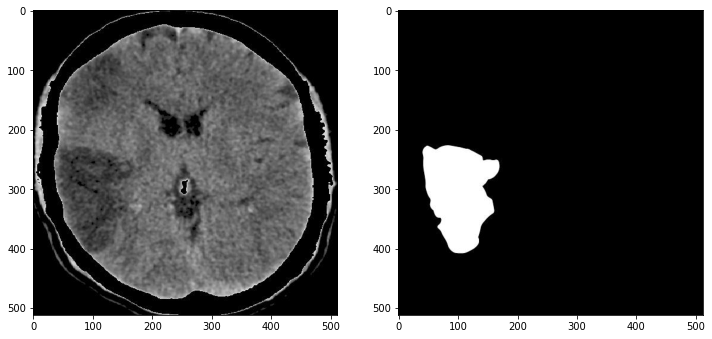

In [ ]:
image_number=random.randint(0,len(train_images))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(train_images[image_number,:, :, 0], cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(train_mask[image_number], (512,512)), cmap='gray')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.25, random_state=42)
np.save(out_dir+"x_train.npy",x_train)
np.save(out_dir+"y_train.npy",y_train)
np.save(out_dir+"x_val.npy",x_val)
np.save(out_dir+"y_val.npy",y_val)
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)
#del train_images, train_mask, x_train, x_val, y_train, y_val

In [ ]:
BACKBONE='resnet34'
preprocess_input=sm.get_preprocessing(BACKBONE)

In [ ]:
x_train=np.load(out_dir + "x_train.npy").astype(np.float32)
y_train=np.load(out_dir + "y_train.npy").astype(np.float32)
x_val=np.load(out_dir + "x_val.npy").astype(np.float32)
y_val=np.load(out_dir + "y_val.npy").astype(np.float32)


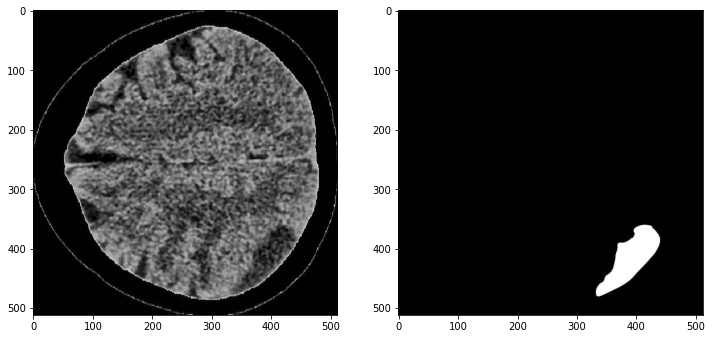

In [ ]:
image_number=random.randint(0,len(x_train))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(x_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (512,512)), cmap='gray')
plt.show()

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
model=sm.Unet(BACKBONE, encoder_weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
85524480/85521592 [==============================] - 1s 0us/step


In [ ]:

model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
filepath="/content/gdrive/MyDrive/Weight/unet_weight_28.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='loss', save_best_only=True)

print(model.summary())

history=model.fit(x_train, 
                  y_train,
                  batch_size=2,
                  epochs=150,
                  verbose=1, 
                  callbacks=[model_checkpoint],
                  validation_data=(x_val, y_val))

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_102 (ZeroPadding (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_102[0][0]         
____________________________________________________________________________________________

In [ ]:
#model.save('/content/gdrive/MyDrive/OutputTraining/Model/model2.hdf5')

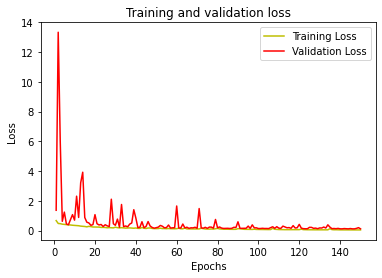

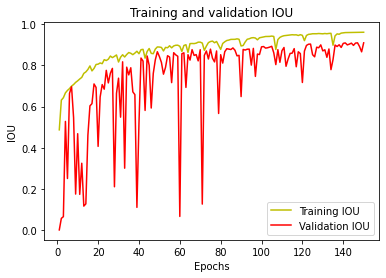

In [ ]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1, len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']
plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
from skimage import io

model.load_weights('/content/gdrive/MyDrive/Weight/unet_weight_28.hdf5')
print('-' * 30)
print('Predicting masks on test data...')
print('-' * 30)
out_predict='/content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/'
num_test = len(x_val)
imgs_mask_test = np.ndarray([num_test,512, 512,1], dtype=np.float32)
for i in range(num_test):
  imgs_mask_test[i] = model.predict([x_val[i:i + 1]], verbose=1)[0]

  #Save dalam bentuk gambar .png
  io.imsave(out_predict + '%04d_TestCase.png' % (i), x_val[i,:,:,0])
  io.imsave(out_predict + '%04d_Predict.png' % (i), imgs_mask_test[i])
  io.imsave(out_predict + '%04d_Mask.png' % (i), y_val[i,:,:,0])



------------------------------
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0015_Predict.png is a low contrast image
  from ipykernel import kernelapp as app


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 39ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 40ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 38ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 38ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 38ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 38ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0047_Predict.png is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0047_Mask.png is a low contrast image
  app.launch_new_instance()


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 38ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0054_Mask.png is a low contrast image
  app.launch_new_instance()


1/1 [==============================] - 0s 37ms/sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0055_Predict.png is a low contrast image
  from ipykernel import kernelapp as app


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0064_Predict.png is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0064_Mask.png is a low contrast image
  app.launch_new_instance()


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 39ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0072_Predict.png is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0072_Mask.png is a low contrast image
  app.launch_new_instance()


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0078_Predict.png is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0078_Mask.png is a low contrast image
  app.launch_new_instance()


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 38ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 39ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 38ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 39ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 40ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 38ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0130_Predict.png is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0130_Mask.png is a low contrast image
  app.launch_new_instance()


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 38ms/sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0138_Predict.png is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0138_Mask.png is a low contrast image
  app.launch_new_instance()


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 38ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 39ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0160_Predict.png is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0160_Mask.png is a low contrast image
  app.launch_new_instance()


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 42ms/sample


1/1 [==============================] - 0s 39ms/sample


1/1 [==============================] - 0s 40ms/sample


1/1 [==============================] - 0s 39ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 38ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 39ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 39ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 42ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 42ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 39ms/sample


1/1 [==============================] - 0s 36ms/sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0198_Predict.png is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0198_Mask.png is a low contrast image
  app.launch_new_instance()


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0205_Predict.png is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0205_Mask.png is a low contrast image
  app.launch_new_instance()


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 39ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 38ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 38ms/sample


1/1 [==============================] - 0s 40ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 39ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 39ms/sample


1/1 [==============================] - 0s 39ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 41ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 41ms/sample


1/1 [==============================] - 0s 39ms/sample


1/1 [==============================] - 0s 40ms/sample


1/1 [==============================] - 0s 36ms/sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0234_Predict.png is a low contrast image
  from ipykernel import kernelapp as app


1/1 [==============================] - 0s 39ms/sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: /content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/0235_Predict.png is a low contrast image
  from ipykernel import kernelapp as app


1/1 [==============================] - 0s 40ms/sample


1/1 [==============================] - 0s 39ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 39ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 37ms/sample


1/1 [==============================] - 0s 38ms/sample


1/1 [==============================] - 0s 38ms/sample


1/1 [==============================] - 0s 36ms/sample


1/1 [==============================] - 0s 38ms/sample


1/1 [==============================] - 0s 39ms/sample


In [ ]:
def dice_coef_np(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

In [ ]:
mean = 0.0
smooth = 1.

for i in range(num_test):
  mean += dice_coef_np(imgs_mask_test[i,:,:, 0], y_val[i,:,:, 0])
    
mean /= num_test
print("Mean Dice Coeff : ", mean)
with open('/content/gdrive/MyDrive/OutputTraining/Enhanced/Epoch 150/dsc.txt', 'w') as writefile:
    writefile.write(str(mean))

Mean Dice Coeff :  0.9448599818874379
